# LLM PROJECT - OPTIMIZATION<p>

In [1]:
from datasets import DatasetDict
new_ds = DatasetDict.load_from_disk('pickles/new_ds_folder')

Because the pipeline doesn't seem to be doing what I need it to, I'm going to use the model step by step.<p>
The same tokenizer and model items from the pipeline will be used. 

In [2]:
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification

In [3]:
model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name,num_labels=7)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Next is performing tokenization, in batches, with truncation and padding. Truncation is necessary because some of the entries are apparently too long for this model, even with stopwords removed. 

In [4]:
def tokenize_process(batch):
    return tokenizer(batch['no_stopword'], return_tensors='pt', truncation=True, padding=True)

In [5]:
tokens_train = new_ds['train'].map(tokenize_process, batched=True)
tokens_test = new_ds['test'].map(tokenize_process, batched=True)

Map:   0%|          | 0/11314 [00:00<?, ? examples/s]

Map:   0%|          | 0/7532 [00:00<?, ? examples/s]

Next is setting up the `trainer`. This includes building some additional functions that will be included in the trainer, along with the `tokenizer` and `model`.<p>
First is `data_collator`, which was a recommendation from the HuggingFace community to help speed up training, and second it a function to `compute_metrics` during training.

In [6]:
import evaluate
import numpy as np
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [7]:
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)  # Get the predicted class labels
    # Compute accuracy
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    # Compute F1 score
    f1 = f1_metric.compute(predictions=predictions, references=labels, average='weighted')
    # Return both metrics
    return {"accuracy": accuracy["accuracy"], "f1": f1["f1"]}

In [8]:
from transformers import TrainingArguments, Trainer
training_args = TrainingArguments(
    output_dir='my_model',
    report_to='none',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1)

trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokens_train,
   eval_dataset=tokens_test,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics)

Then it's time to train the model. Since I have a gpu this will hopefully go reasonably fast. 

In [9]:
trainer.train()

  0%|          | 0/708 [00:00<?, ?it/s]

{'loss': 0.8809, 'grad_norm': 8.73812198638916, 'learning_rate': 5.8757062146892665e-06, 'epoch': 0.71}
{'train_runtime': 332.2057, 'train_samples_per_second': 34.057, 'train_steps_per_second': 2.131, 'train_loss': 0.8063561175502626, 'epoch': 1.0}


TrainOutput(global_step=708, training_loss=0.8063561175502626, metrics={'train_runtime': 332.2057, 'train_samples_per_second': 34.057, 'train_steps_per_second': 2.131, 'total_flos': 1498869787551744.0, 'train_loss': 0.8063561175502626, 'epoch': 1.0})

Above shows a loss of 0.88, and a training loss of 0.81 (rounded). <p>
I can also get evaluation metrics from the trainer.

In [10]:
results_train = trainer.evaluate(eval_dataset=tokens_train)
results_test = trainer.evaluate(eval_dataset=tokens_test)

  0%|          | 0/708 [00:00<?, ?it/s]

  0%|          | 0/471 [00:00<?, ?it/s]

In [11]:
print("Training Evaluation Results:", results_train)
print("Test Evaluation Results:", results_test)

Training Evaluation Results: {'eval_loss': 0.5214135646820068, 'eval_accuracy': 0.8180130811384125, 'eval_f1': 0.8017958657777268, 'eval_runtime': 116.832, 'eval_samples_per_second': 96.84, 'eval_steps_per_second': 6.06, 'epoch': 1.0}
Test Evaluation Results: {'eval_loss': 0.6322040557861328, 'eval_accuracy': 0.7741635687732342, 'eval_f1': 0.759058270946797, 'eval_runtime': 76.5783, 'eval_samples_per_second': 98.357, 'eval_steps_per_second': 6.151, 'epoch': 1.0}


These show a much lower loss value, and I am not entirely sure why. Possibly because this is for the trained model rather than the in-training model?<p>
Accuracy and f1 are very similar. F1 is slightly lower, which I think means that although the model did a decent job of accounting for under-represented categories, it still had some problems. <p>
Drop between training and test is similar for both accuracy and f1, which is good. 

In [12]:
import torch

In [37]:
import pandas as pd
ds_test = pd.read_pickle('pickles/ds_test.pkl')

texts = ds_test['no_stopword'].tolist()

In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
batch_size = 8

In [39]:
def predict_in_batches(texts, batch_size):
    predictions = []
    # Iterate over texts in smaller batches
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        
        # Tokenize the batch
        inputs = tokenizer(batch, return_tensors='pt', padding=True, truncation=True, max_length=512)
        
        # Move inputs to the same device as the model
        inputs = {key: value.to(device) for key, value in inputs.items()}

        # Make predictions
        with torch.no_grad():  # no need to compute gradients
            outputs = model(**inputs)

        # Get predicted classes
        logits = outputs.logits
        predicted_classes = torch.argmax(logits, dim=-1).cpu().numpy()
        
        predictions.extend(predicted_classes)

    return predictions

In [ ]:
predicted_classes = predict_in_batches(texts, batch_size)
ds_test['predicted'] = predicted_classes

ChatGPT had to troubleshoot that code, but now that it works I can visualize the predicitons of the test set:

([<matplotlib.axis.YTick at 0x127a16e1f40>,
 [Text(0, 0, '0'),
  Text(0, 500, '500'),
  Text(0, 1000, '1000'),
  Text(0, 1500, '1500'),
  Text(0, 2000, '2000')])

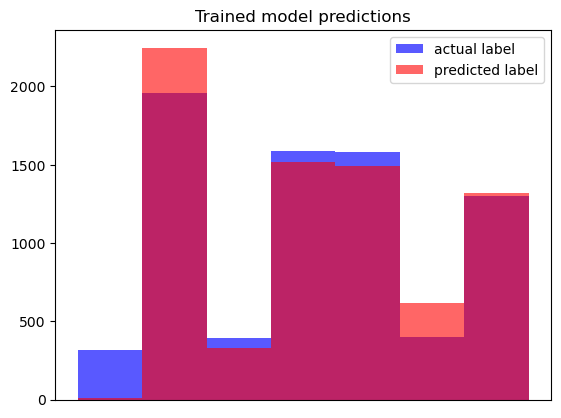

In [57]:
import matplotlib.pyplot as plt

plt.hist(ds_test['simple_topic'],bins=7,color='blue',alpha=0.65,label='actual label')
plt.hist(ds_test['predicted'],bins=7,color='red',alpha=0.6,label='predicted label')
plt.legend()
plt.title('Trained model predictions')
plt.xticks([])
plt.yticks(np.arange(0,2500,500))


And it does show that there was an entire category that the model failed to learn, which seems to explain the lower f1 score. 

I suspect 'optimization' was also supposed to include some kind of hyperparameter tuning, rather than simply running the trainer function on the model, but while I was still using only Google collab, being stuck with the CPU processing meant that everything took forever. And before that, I had a terrible time understanding all of the documentation to the point of being able to get something to run at _all_, so with 9+ hours to run the model the first time, there just was not time. If I had been using my own computer from the start, and done it all in VSCode rather than moving it in here to submit, I would have plenty of time, as I have a GPU.